ENERJİSA Competition Energy Forecasting

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from suntime import Sun
import pytz
import warnings
from flaml import AutoML
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
warnings.filterwarnings(action='ignore')

# 1 - Preprocessing

In [2]:
df_temp = pd.read_csv('temperature.csv',sep=';')
df_temp.replace(',','.',regex=True,inplace=True)
df_temp.head(2)

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
0,01Jan2019 0:00:00,-1.70,-6.10,75.30,3.60,60.0,10.0,6.30
1,01Jan2019 1:00:00,-1.80,-5.30,75.30,2.60,70.0,10.0,4.50


In [3]:
df_gen = pd.read_csv('generation.csv',sep=';')
df_gen.replace(',','.',regex=True,inplace=True)
df_gen.head(2)

,DateTime,Generation
0,01Jan2019 0:00:00,0.0000000
1,01Jan2019 1:00:00,0.0000000


In [4]:
df_samp = pd.read_csv('sample_submission.csv',sep=',')
df_samp.head(2)

,DateTime,Generation
0,01Dec2021 0:00:00,0
1,01Dec2021 1:00:00,0


In [5]:
df_temp.isna().sum()

DateTime                 95
AirTemperature           95
ComfortTemperature       95
RelativeHumidity         95
WindSpeed                95
WindDirection            95
WWCode                 6349
EffectiveCloudCover      95
dtype: int64

In [6]:
df_temp.DateTime = pd.to_datetime(df_temp.DateTime,infer_datetime_format=True)
df_temp.head(2)

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
0,2019-01-01 00:00:00,-1.70,-6.10,75.30,3.60,60.0,10.0,6.30
1,2019-01-01 01:00:00,-1.80,-5.30,75.30,2.60,70.0,10.0,4.50


In [7]:
#***
df_temp.iloc[:,1:] = df_temp.iloc[:,1:].astype('float')
df_temp

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
0,2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3
1,2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5
2,2019-01-01 02:00:00,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5
3,2019-01-01 03:00:00,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6
4,2019-01-01 04:00:00,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5
...,...,...,...,...,...,...,...,...
26394,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26395,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26396,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26397,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_temp.describe()

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
count,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,20050.000000,26304.000000
mean,13.741522,13.239397,54.352832,1.655931,87.463960,13.095711,2.614051
std,9.379876,9.767058,22.566688,1.353196,100.762932,24.471306,2.497609
min,-13.100000,-19.300000,1.600000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,5.100000,36.600000,0.500000,20.000000,0.000000,0.000000
50%,13.400000,13.000000,55.100000,1.500000,30.000000,3.000000,2.100000
75%,21.000000,21.200000,72.500000,2.600000,170.000000,10.000000,5.000000
max,39.000000,37.200000,100.000000,13.400000,360.000000,99.000000,8.000000


In [9]:
#Check if date shift exists
df_temp.DateTime.index

RangeIndex(start=0, stop=26399, step=1)

In [10]:
#check continuity of nan values
df_temp[df_temp.DateTime.isna()].index.values.all() == np.arange(26304,26399,1).all()

True

In [11]:
#Check if nan values are dropped, whole dataset dates cover full days wwithout any exception like 16 hours in a day.
last_nan_index = df_temp[df_temp.DateTime.isna()].index[0]
df_temp.DateTime.iloc[23] , df_temp.DateTime.iloc[last_nan_index-1]

(Timestamp('2019-01-01 23:00:00'), Timestamp('2021-12-31 23:00:00'))

In [12]:
#drop date nan values
df_temp.dropna(subset=['DateTime'],inplace=True)
df_temp

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
0,2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3
1,2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5
2,2019-01-01 02:00:00,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5
3,2019-01-01 03:00:00,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6
4,2019-01-01 04:00:00,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5
...,...,...,...,...,...,...,...,...
26299,2021-12-31 19:00:00,8.9,8.4,62.0,0.0,0.0,2.0,1.5
26300,2021-12-31 20:00:00,8.0,7.6,65.9,0.0,0.0,2.0,1.5
26301,2021-12-31 21:00:00,7.3,6.9,70.1,0.0,0.0,6.0,1.5
26302,2021-12-31 22:00:00,6.2,5.9,75.0,0.0,0.0,2.0,2.0


In [13]:
#check nan values of whole columns. There are some nan values in WWCode
df_temp.isna().sum()

DateTime                  0
AirTemperature            0
ComfortTemperature        0
RelativeHumidity          0
WindSpeed                 0
WindDirection             0
WWCode                 6254
EffectiveCloudCover       0
dtype: int64

In [14]:
df_temp[df_temp.WWCode.isna()].index

Int64Index([  10,   11,   12,   13,   14,   15,   16,   17,   18,   19,
            ...
            7818, 7819, 7820, 7821, 7822, 7823, 7825, 7826, 7828, 7830],
           dtype='int64', length=6254)

In [15]:
#In this part, WWCode nan values are filled according to 2 values which are nearest values by date.
df_temp.loc[df_temp.WWCode.isna(),'WWCode'] = -1
df_temp.loc[df_temp.WWCode==0,'WWCode'] = -1
for i in df_temp[df_temp.WWCode==-1].index:
    for j in range(i-1,0,-24):
        wwcode_previous = 0
        diff_p = -1
        if df_temp.WWCode.iloc[j] != -1:
            wwcode_previous = df_temp.WWCode.iloc[j]
            diff_p = abs(i-j)
            break
    for j in range(i,len(df_temp),24):
        wwcode_next = 0
        diff_n = -1
        if df_temp.WWCode.iloc[j] != -1:
            wwcode_next = df_temp.WWCode.iloc[j]
            diff_n = abs(i-j)
            break
    if diff_p < diff_n:
        df_temp.WWCode.iloc[i] = wwcode_previous
    else:
        df_temp.WWCode.iloc[i] = wwcode_next
    

In [16]:
#Now, there is no any nan values anymore.
df_temp.isna().sum()

DateTime               0
AirTemperature         0
ComfortTemperature     0
RelativeHumidity       0
WindSpeed              0
WindDirection          0
WWCode                 0
EffectiveCloudCover    0
dtype: int64

<BarContainer object of 54 artists>

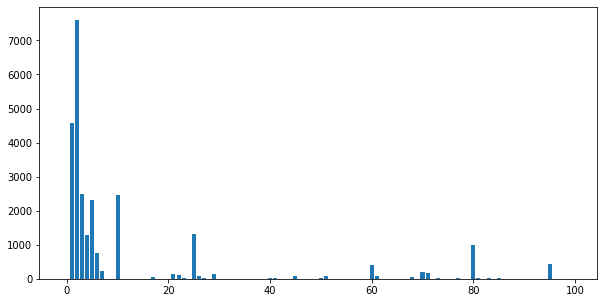

In [17]:
#distribution of WWCode values
plt.figure(figsize=(10,5))
plt.bar(df_temp.WWCode.value_counts().index,df_temp.WWCode.value_counts())      

# 2- Feature Engineering

In [18]:
#Time features are added.
df_temp['Hour'] = df_temp.DateTime.dt.hour
df_temp['Day'] = df_temp.DateTime.dt.day
df_temp['Dayofweek'] = df_temp.DateTime.dt.dayofweek
df_temp['Weekofyear'] = df_temp.DateTime.dt.weekofyear
df_temp['Month'] = df_temp.DateTime.dt.month
df_temp['Quarter'] = df_temp.DateTime.dt.quarter
df_temp['Year'] = df_temp.DateTime.dt.year

In [19]:
df_temp.head(2)

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Hour,Day,Dayofweek,Weekofyear,Month,Quarter,Year
0,2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3,0,1,1,1,1,1,2019
1,2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5,1,1,1,1,1,1,2019


In [20]:
#WindDirection

In [21]:
#WindDirection column actually means angle of wind, so values are rated for 0 to 360 and its sin and cos values are also added. 
df_temp['WindDirection_sin'] = np.sin(2*np.pi*df_temp['WindDirection']/df_temp['WindDirection'].max())
df_temp['WindDirection_cos'] = np.cos(2*np.pi*df_temp['WindDirection']/df_temp['WindDirection'].max())
df_temp.head(3)

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Hour,Day,Dayofweek,Weekofyear,Month,Quarter,Year,WindDirection_sin,WindDirection_cos
0,2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3,0,1,1,1,1,1,2019,0.866025,0.500000
1,2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5,1,1,1,1,1,1,2019,0.939693,0.342020
2,2019-01-01 02:00:00,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5,2,1,1,1,1,1,2019,0.984808,0.173648


In [22]:
#for sun angle calculation
ankara_coord = [40.239, 33.029]
sun = Sun(ankara_coord[0], ankara_coord[1])
tz =pytz.timezone('Europe/Istanbul')

In [23]:
#check if it is day or night
def is_day(x):
    sun_rise_time = Sun.get_local_sunrise_time(sun,x.DateTime.date(),tz).hour
    sun_set_time = Sun.get_local_sunset_time(sun,x.DateTime.date(),tz).hour
    if x.DateTime.hour in np.arange(sun_rise_time,sun_set_time+1):
        return 1
    else:
        return 0

In [24]:
#is_day column is added.
df_temp['is_day'] = df_temp.apply(lambda x: is_day(x),axis=1)

In [25]:
#Sun angle information is extracted according to sunrise and sunset time of current location.
def get_sun_angle(x):
    sun_rise_time = Sun.get_local_sunrise_time(sun,x.DateTime.date(),tz).hour
    sun_set_time = Sun.get_local_sunset_time(sun,x.DateTime.date(),tz).hour
    return np.sin(np.pi*(x.Hour - sun_rise_time)/(sun_set_time))

In [26]:
#sun_angle column is added.
df_temp['sun_angle'] = df_temp.apply(lambda x: get_sun_angle(x),axis=1)

In [27]:
df_temp.head(2)

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Hour,Day,Dayofweek,Weekofyear,Month,Quarter,Year,WindDirection_sin,WindDirection_cos,is_day,sun_angle
0,2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3,0,1,1,1,1,1,2019,0.866025,0.50000,0,-0.995734
1,2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5,1,1,1,1,1,1,2019,0.939693,0.34202,0,-0.961826


In [28]:
#Test datasetindeki kategorik datalarda tutarsızlık var mı kontrol ediliyor.

In [29]:
#check if dates of test datas have any inconsistency
df_test = df_temp[df_temp.DateTime>dt.datetime(2021,11,30,23)]
df_test

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Hour,Day,Dayofweek,Weekofyear,Month,Quarter,Year,WindDirection_sin,WindDirection_cos,is_day,sun_angle
25560,2021-12-01 00:00:00,4.9,4.7,86.9,1.0,210.0,60.0,7.3,0,1,2,48,12,4,2021,-0.50000,-0.866025,0,-0.961826
25561,2021-12-01 01:00:00,4.9,4.7,86.9,0.5,210.0,61.0,6.0,1,1,2,48,12,4,2021,-0.50000,-0.866025,0,-0.895163
25562,2021-12-01 02:00:00,4.5,4.3,84.4,1.0,210.0,61.0,6.0,2,1,2,48,12,4,2021,-0.50000,-0.866025,0,-0.798017
25563,2021-12-01 03:00:00,3.7,3.5,86.8,1.5,200.0,21.0,7.3,3,1,2,48,12,4,2021,-0.34202,-0.939693,0,-0.673696
25564,2021-12-01 04:00:00,3.7,3.5,86.8,1.0,210.0,68.0,6.5,4,1,2,48,12,4,2021,-0.50000,-0.866025,0,-0.526432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2021-12-31 19:00:00,8.9,8.4,62.0,0.0,0.0,2.0,1.5,19,31,4,52,12,4,2021,0.00000,1.000000,0,0.895163
26300,2021-12-31 20:00:00,8.0,7.6,65.9,0.0,0.0,2.0,1.5,20,31,4,52,12,4,2021,0.00000,1.000000,0,0.798017
26301,2021-12-31 21:00:00,7.3,6.9,70.1,0.0,0.0,6.0,1.5,21,31,4,52,12,4,2021,0.00000,1.000000,0,0.673696
26302,2021-12-31 22:00:00,6.2,5.9,75.0,0.0,0.0,2.0,2.0,22,31,4,52,12,4,2021,0.00000,1.000000,0,0.526432


In [30]:
#train datas are seperated from test datas.
df_train = df_temp[df_temp.DateTime.isin(df_test.DateTime)==False]
df_train

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Hour,Day,Dayofweek,Weekofyear,Month,Quarter,Year,WindDirection_sin,WindDirection_cos,is_day,sun_angle
0,2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,10.0,6.3,0,1,1,1,1,1,2019,0.866025,0.500000,0,-0.995734
1,2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,10.0,4.5,1,1,1,1,1,1,2019,0.939693,0.342020,0,-0.961826
2,2019-01-01 02:00:00,-2.0,-6.0,74.7,3.1,80.0,10.0,5.5,2,1,1,1,1,1,2019,0.984808,0.173648,0,-0.895163
3,2019-01-01 03:00:00,-1.9,-5.9,76.4,3.1,60.0,10.0,7.6,3,1,1,1,1,1,2019,0.866025,0.500000,0,-0.798017
4,2019-01-01 04:00:00,-2.0,-7.1,76.4,4.6,60.0,10.0,6.5,4,1,1,1,1,1,2019,0.866025,0.500000,0,-0.673696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25555,2021-11-30 19:00:00,7.1,5.2,76.8,3.1,220.0,25.0,6.0,19,30,1,48,11,4,2021,-0.642788,-0.766044,0,0.798017
25556,2021-11-30 20:00:00,7.1,5.7,75.2,2.1,250.0,80.0,6.0,20,30,1,48,11,4,2021,-0.939693,-0.342020,0,0.673696
25557,2021-11-30 21:00:00,5.8,3.1,83.4,4.1,280.0,80.0,7.0,21,30,1,48,11,4,2021,-0.984808,0.173648,0,0.526432
25558,2021-11-30 22:00:00,5.0,3.3,81.0,2.1,240.0,60.0,6.0,22,30,1,48,11,4,2021,-0.866025,-0.500000,0,0.361242


In [31]:
#In dataset, there is only one column described as categorical feature.
#So it needs to check if there is a different category in test datas which is not exist in train data.
set(df_test.WWCode.tolist()) - set(df_train.WWCode.tolist())

{0.0, 84.0}

In [32]:
#check if any nan value exists in test data.
df_test.isna().sum()

DateTime               0
AirTemperature         0
ComfortTemperature     0
RelativeHumidity       0
WindSpeed              0
WindDirection          0
WWCode                 0
EffectiveCloudCover    0
Hour                   0
Day                    0
Dayofweek              0
Weekofyear             0
Month                  0
Quarter                0
Year                   0
WindDirection_sin      0
WindDirection_cos      0
is_day                 0
sun_angle              0
dtype: int64

In [33]:
#There is only 2 nan value, so it is labeled as 0 which means unseen data.
def fill_wwcode_for_test(x):
    try:
        if x.WWCode == 0:
            return df_test[df_test.Hour == x.Hour].WWCode.mode()[0]
        else:
            return x.WWCode
    except:
        print('something s wrong!')
df_test['WWCode'] = df_test.apply(lambda x: fill_wwcode_for_test(x),axis=1)

In [34]:
#WWCode da 84 kategorisi train verilerinde bulunmadığı için, bulunanlardan en yakını ile değiştirilir.

In [35]:
df_test[df_test.WWCode == 84]

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Hour,Day,Dayofweek,Weekofyear,Month,Quarter,Year,WindDirection_sin,WindDirection_cos,is_day,sun_angle
25921,2021-12-16 01:00:00,3.5,3.3,93.2,1.0,230.0,84.0,5.5,1,16,3,50,12,4,2021,-0.766044,-0.642788,0,-0.961826


In [36]:
#84 is unique value for test data. So it is replaced with 83 which has nearest mean to 84
df_test.loc[df_test.WWCode == 84,'WWCode'] = 83

<AxesSubplot:>

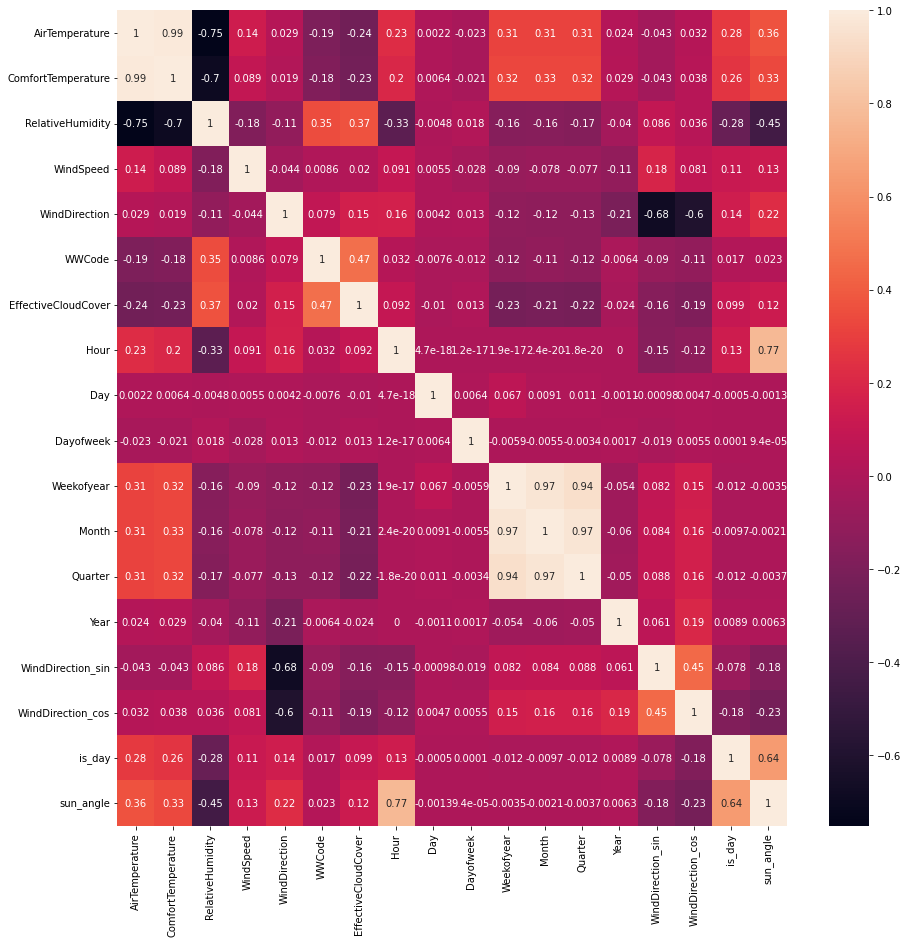

In [37]:
#Correlation matrix of columns
import seaborn as sb
corr = df_train.corr()
plt.figure(figsize=(15,15))
sb.heatmap(corr,annot=True)

In [38]:
#Most correlated columns are considered as dublicate, so one of them is dropped.
df_train.drop(columns=['Month','ComfortTemperature'],inplace=True)

In [39]:
#y_label dataset
df_gen = pd.read_csv('generation.csv',sep=';')
df_gen = df_gen.replace(',','.',regex=True)
df_gen

,DateTime,Generation
0,01Jan2019 0:00:00,0.0000000
1,01Jan2019 1:00:00,0.0000000
2,01Jan2019 2:00:00,0.0000080
3,01Jan2019 3:00:00,0.0000000
4,01Jan2019 4:00:00,0.0000080
...,...,...
26299,NaN,NaN
26300,NaN,NaN
26301,NaN,NaN
26302,NaN,NaN


In [40]:
##check continuity of dates
(df_gen[df_gen.DateTime.isna()].index == np.arange(25560,26304,1)).all()

True

In [41]:
df_gen.dropna(subset=['DateTime'],inplace=True)
df_gen.DateTime = pd.to_datetime(df_gen.DateTime)
df_gen

,DateTime,Generation
0,2019-01-01 00:00:00,0.0000000
1,2019-01-01 01:00:00,0.0000000
2,2019-01-01 02:00:00,0.0000080
3,2019-01-01 03:00:00,0.0000000
4,2019-01-01 04:00:00,0.0000080
...,...,...
25555,2021-11-30 19:00:00,0.0000000
25556,2021-11-30 20:00:00,0.0000000
25557,2021-11-30 21:00:00,0.0000000
25558,2021-11-30 22:00:00,0.0000000


In [42]:
#Features and y_labels are merged into one dataframe.
df_train = df_train.merge(df_gen,on='DateTime',how='inner')

In [43]:
df_train.columns

Index(['DateTime', 'AirTemperature', 'RelativeHumidity', 'WindSpeed',
       'WindDirection', 'WWCode', 'EffectiveCloudCover', 'Hour', 'Day',
       'Dayofweek', 'Weekofyear', 'Quarter', 'Year', 'WindDirection_sin',
       'WindDirection_cos', 'is_day', 'sun_angle', 'Generation'],
      dtype='object')

In [44]:
df_train

,DateTime,AirTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Hour,Day,Dayofweek,Weekofyear,Quarter,Year,WindDirection_sin,WindDirection_cos,is_day,sun_angle,Generation
0,2019-01-01 00:00:00,-1.7,75.3,3.6,60.0,10.0,6.3,0,1,1,1,1,2019,0.866025,0.500000,0,-0.995734,0.0000000
1,2019-01-01 01:00:00,-1.8,75.3,2.6,70.0,10.0,4.5,1,1,1,1,1,2019,0.939693,0.342020,0,-0.961826,0.0000000
2,2019-01-01 02:00:00,-2.0,74.7,3.1,80.0,10.0,5.5,2,1,1,1,1,2019,0.984808,0.173648,0,-0.895163,0.0000080
3,2019-01-01 03:00:00,-1.9,76.4,3.1,60.0,10.0,7.6,3,1,1,1,1,2019,0.866025,0.500000,0,-0.798017,0.0000000
4,2019-01-01 04:00:00,-2.0,76.4,4.6,60.0,10.0,6.5,4,1,1,1,1,2019,0.866025,0.500000,0,-0.673696,0.0000080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25555,2021-11-30 19:00:00,7.1,76.8,3.1,220.0,25.0,6.0,19,30,1,48,4,2021,-0.642788,-0.766044,0,0.798017,0.0000000
25556,2021-11-30 20:00:00,7.1,75.2,2.1,250.0,80.0,6.0,20,30,1,48,4,2021,-0.939693,-0.342020,0,0.673696,0.0000000
25557,2021-11-30 21:00:00,5.8,83.4,4.1,280.0,80.0,7.0,21,30,1,48,4,2021,-0.984808,0.173648,0,0.526432,0.0000000
25558,2021-11-30 22:00:00,5.0,81.0,2.1,240.0,60.0,6.0,22,30,1,48,4,2021,-0.866025,-0.500000,0,0.361242,0.0000000


In [45]:
df_train.iloc[:,1:] = df_train.iloc[:,1:].astype('float')

# 3- Modeling

In [46]:
#Train and evaluation datas are seperated.
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(columns=['Generation','DateTime']), df_train.loc[:,['Generation']], test_size=0.2, random_state=40)

In [47]:
#AutoML function is useful for detecting most optimal model as its metric,task and time_budget.
#After finishing whole iteration of this function, it is possible to learn best estimator and its best configurations.
automl3 = AutoML()
settings = {
    "time_budget": 500,  
    "metric": 'rmse',
    "estimator_list": ['lgbm','xgboost','catboost'],
    "task": 'regression',
}
automl3.fit(X_train=X_train, y_train=y_train.values, **settings)

[flaml.automl: 04-27 10:52:50] {2055} INFO - task = regression
[flaml.automl: 04-27 10:52:50] {2057} INFO - Data split method: uniform
[flaml.automl: 04-27 10:52:50] {2061} INFO - Evaluation method: cv
[flaml.automl: 04-27 10:52:50] {2142} INFO - Minimizing error metric: rmse
[flaml.automl: 04-27 10:52:50] {2200} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost']
[flaml.automl: 04-27 10:52:50] {2453} INFO - iteration 0, current learner lgbm
[flaml.automl: 04-27 10:52:51] {2568} INFO - Estimated sufficient time budget=8407s. Estimated necessary time budget=15s.
[flaml.automl: 04-27 10:52:51] {2615} INFO -  at 0.9s,	estimator lgbm's best error=96.3963,	best estimator lgbm's best error=96.3963
[flaml.automl: 04-27 10:52:51] {2453} INFO - iteration 1, current learner lgbm
[flaml.automl: 04-27 10:52:51] {2615} INFO -  at 1.0s,	estimator lgbm's best error=96.3963,	best estimator lgbm's best error=96.3963
[flaml.automl: 04-27 10:52:51] {2453} INFO - iteration 2, current

In [48]:
#best estimator is xgboost
automl3.best_estimator

'lgbm'

In [49]:
xgboost_best_config = automl3.best_config
xgboost_best_config

{'n_estimators': 1291,
 'num_leaves': 64,
 'min_child_samples': 3,
 'learning_rate': 0.06027660054618541,
 'log_max_bin': 7,
 'colsample_bytree': 0.8288184974853621,
 'reg_alpha': 0.10663872566095946,
 'reg_lambda': 0.005971607061360192}

In [50]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor(**xgboost_best_config)
model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')

[0]	validation_0-rmse:143.19064
[1]	validation_0-rmse:134.99474
[2]	validation_0-rmse:127.46370
[3]	validation_0-rmse:120.35133
[4]	validation_0-rmse:113.83796
[5]	validation_0-rmse:107.74297
[6]	validation_0-rmse:101.96686
[7]	validation_0-rmse:96.44769
[8]	validation_0-rmse:91.30566
[9]	validation_0-rmse:86.41146
[10]	validation_0-rmse:81.84342
[11]	validation_0-rmse:77.71663
[12]	validation_0-rmse:73.81090
[13]	validation_0-rmse:70.14794
[14]	validation_0-rmse:66.78293
[15]	validation_0-rmse:63.58664
[16]	validation_0-rmse:60.59617
[17]	validation_0-rmse:57.76261
[18]	validation_0-rmse:55.20378
[19]	validation_0-rmse:52.62653
[20]	validation_0-rmse:50.41096
[21]	validation_0-rmse:48.12090
[22]	validation_0-rmse:46.00507
[23]	validation_0-rmse:44.25798
[24]	validation_0-rmse:42.47394
[25]	validation_0-rmse:40.77707
[26]	validation_0-rmse:39.30230
[27]	validation_0-rmse:37.92060
[28]	validation_0-rmse:36.66986
[29]	validation_0-rmse:35.48705
[30]	validation_0-rmse:34.63267
[31]	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8288184974853621, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.06027660054618541, log_max_bin=7, max_delta_step=0,
             max_depth=6, min_child_samples=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1291, n_jobs=12,
             num_leaves=64, num_parallel_tree=1, random_state=0,
             reg_alpha=0.10663872566095946, reg_lambda=0.005971607061360192,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [51]:
val_pred = model_xgb.predict(X_val)
print('RMSE of model is: ',(mean_squared_error(y_val,val_pred))**0.5)

RMSE of model is:  17.29664748593266


In [52]:
#submission test datas are predicted.
pred_test_xgb = model_xgb.predict(df_test.drop(columns=['DateTime']))

ValueError: feature_names mismatch: ['AirTemperature', 'RelativeHumidity', 'WindSpeed', 'WindDirection', 'WWCode', 'EffectiveCloudCover', 'Hour', 'Day', 'Dayofweek', 'Weekofyear', 'Quarter', 'Year', 'WindDirection_sin', 'WindDirection_cos', 'is_day', 'sun_angle'] ['AirTemperature', 'ComfortTemperature', 'RelativeHumidity', 'WindSpeed', 'WindDirection', 'WWCode', 'EffectiveCloudCover', 'Hour', 'Day', 'Dayofweek', 'Weekofyear', 'Month', 'Quarter', 'Year', 'WindDirection_sin', 'WindDirection_cos', 'is_day', 'sun_angle']
training data did not have the following fields: ComfortTemperature, Month

In [ ]:
#model_cat = CatBoostRegressor(loss_function='RMSE')
#model_cat.fit(X_train, y_train,
#        eval_set = (X_val, y_val),
#        use_best_model = True,
#        early_stopping_rounds = 10,
#        verbose_eval=2
#        )

In [ ]:
df_sample = pd.read_csv('sample_submission.csv')
df_samp.head(2)

,DateTime,Generation
0,01Dec2021 0:00:00,0
1,01Dec2021 1:00:00,0


In [ ]:
#night times of any days are considered as useless for generating solar energy.So Energy generation prediction of these day
#are directly labeled as 0.
df_sample['Generation'] = pred_test_xgb
def delete_nights(x):
    if pd.to_datetime(x.DateTime).hour in [21,22,23,1,2,3,4,5]:
        return 0
    else:
        return x.Generation
df_sample['Generation'] = df_sample.apply(lambda x: delete_nights(x),axis=1)
df_sample

,DateTime,Generation
0,01Dec2021 0:00:00,-10.586464
1,01Dec2021 1:00:00,0.000000
2,01Dec2021 2:00:00,0.000000
3,01Dec2021 3:00:00,0.000000
4,01Dec2021 4:00:00,0.000000
...,...,...
739,31Dec2021 19:00:00,-4.040695
740,31Dec2021 20:00:00,0.558593
741,31Dec2021 21:00:00,0.000000
742,31Dec2021 22:00:00,0.000000


In [ ]:
#df_sample.to_csv('submitv2.csv',index=False)